# Classifying Galaxies

In [4]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import  jax
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import pickle
import datetime;datetime.datetime.now()
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','FuncAnimation',
                       'HTML','itertools','pickle','testFunc','jnp','jax','jit']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

Goal: 66% accuracy

Read data from UIUC PHYS 246 dataset

In [7]:
import urllib.request
url = "https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz"
filename = "dataG.pkl.gz"
urllib.request.urlretrieve(url, filename)

('dataG.pkl.gz', <http.client.HTTPMessage at 0x23f8b6355b0>)

Unpack with gzip

In [8]:
%%time
import gzip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(gzip.open("dataG.pkl.gz",'rb'))

CPU times: total: 2.48 s
Wall time: 2.55 s


* `train_images_raw` - images in the training set, shape: (17457, 69, 69, 1)
* `train_labels`     - labels that explain the image classification for the training set
* `test_images_raw`  - images for the test set, shape: (1940,69,69,1)
* `test_labels`      - labels that explain the image classification for the test set

Original data has 3 channels--g,r,i bands--while this dataset has only 1 (g). This set also only includes a subset of labels.

To use full data provided:
```python
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
!unzip data.pkl.zip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(open("data.pkl",'rb'))
```

and then change the reshape commands below

Plot galaxy images

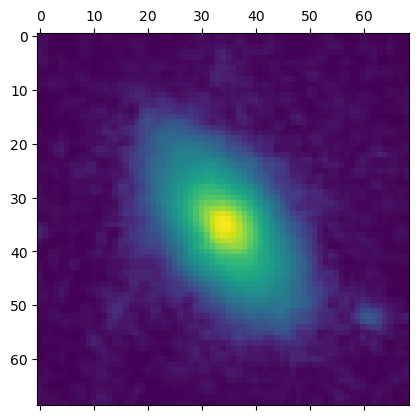

In [9]:
#plot me here!
plt.matshow(train_images_raw[0][:,:,0])

See correct label for this galaxy

In [10]:
## print out the label
print(train_labels[0])

[0. 0. 1. 0. 0.]


`1` in the second place: smooth completely round galaxy. (ordering is [here](https://astronn.readthedocs.io/en/latest/galaxy10.html)).

```
Galaxy10 dataset (25753 images)
├── *0* Class 0 (3461 images): Disk, Face-on, No Spiral
├── *1* Class 1 (6997 images): Smooth, Completely round
├── *2* Class 2 (6292 images): Smooth, in-between round
├── Class 3 (394 images): Smooth, Cigar shaped
├── *3* Class 4 (3060 images): Disk, Edge-on, Rounded Bulge
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge
├── Class 6 (1089 images): Disk, Edge-on, No Bulge
├── *4* Class 7 (1932 images): Disk, Face-on, Tight Spiral
├── Class 8 (1466 images): Disk, Face-on, Medium Spiral
└── Class 9 (1045 images): Disk, Face-on, Loose Spiral
```
![Galaxy10 dataset](https://astronn.readthedocs.io/en/latest/_images/galaxy10_example.png)

Using 5 sets, which are indicated with the `*#*`

Display image and label for image 98, should be a disk galaxy

[1. 0. 0. 0. 0.]


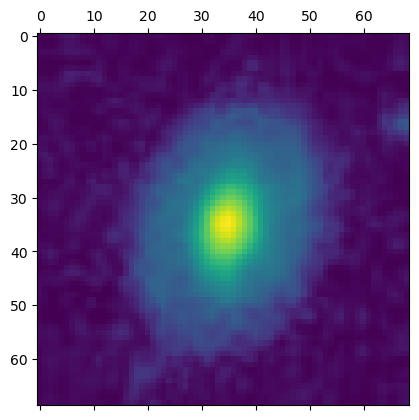

In [11]:
plt.matshow(train_images_raw[98][:,:,0])
print(train_labels[98])

Check data shape

In [12]:
print(np.shape(train_images_raw))

(17457, 69, 69, 1)


We have 17457 images.  Each image is a $69 \times 69 \times 1$ image.  We are going to give these pictures as inputs to our neural network.  It will be easier to give them a big $69 \times 69 \times 1$ vector then a tensor like this.  Therefore, we will reshape our data and normalize it (divide all vectors by 256).

In [14]:
train_images = train_images_raw.reshape(len(train_images_raw),69*69*1)/256.
test_images = test_images_raw.reshape(len(test_images_raw),69*69*1)/256.

### Neural Network

Note: jax.numpy necessary instead of numpy for gradient descent calculations.

Neural network, taking in input image and outputting size-5 vector: 

The equation for how to do this is
 $v_{out} = 1.0/(1+\exp(-(W_2 \textrm{tanh}(W_1 v_{in} + b_1) +b_2))$
where
* W1 is a size d x 4761 matrix
* W2 is a size 5 x d matrix
* b1 is a size d vector
* b2 is a size 5 vector

The last term: $1/(1+e^{-x})$ ensures that all the numbers in $v_{out}$ are between 0 and 1.

To make this function work in parallel on multiple $v_{in}$'s simultaneously, we will supply them as a large matrix $V_{in}$ (of size ```(17457, 4761)```) and transpose accordingly for valid matrix multiplication:

$$ v_{out} = \left(1+\exp\left[-\left(\left[W_2 \cdot \mathrm{tanh}(W_1 \cdot V_{in}^\top + b_1)^\top\right]^\top +b_2\right)^\top\right]\right)^{-1} $$

Function
```python
def net(params,imageVector):
   # W1=params[0]
   # b1=params[1]
   # W2= params[2]
   # b2 = params[3]
   # return output
```
where params is a list that contains these parameters and imageVector is one of our reshaped images.


Using d = 100, we will generate random parameters.


In [16]:
params = dict()
d = 100
params[0] = 0.1 * np.random.randn(d, 4761)
params[1] = 0.1 * np.random.randn(d)
params[2] = 0.1 * np.random.randn(5, d)
params[3] = 0.1 * np.random.randn(5)

def net(params, imageVector):
  W1 = params[0]
  b1 = params[1]
  W2 = params[2]
  b2 = params[3]
  return 1 / (1 + jnp.exp(-(jnp.dot(W2, jnp.tanh(jnp.dot(W1, imageVector) + b1)) + b2)))

outputVector = net(params, train_images[3])
print(f"Spot {jnp.argmax(outputVector)}")

Spot 4


### c. A measure of goodness

To quantify how good our neural network is, we will use two things:

(1) **Cross-entropy**

$$ \sum_i -y_i \log(a_i) - (1-y_i)\log(1-a_i)$$

where $y_i$ is the $i'$th component of the exact label and $a_i$ is the $i'$th component of the label you get as output from the neural network.  

We will take our parameters, image vector, and run the network to get our output. We will then check the cross entropy and try to minimize it.


In [34]:
def loss(params, imageVector, correctLabel):
  a = net(params, imageVector)
  sum = 0
  for i in range(len(correctLabel)):
    sum += -correctLabel[i] * jnp.log(a[i]) - (1 - correctLabel[i]) * jnp.log(1 - a[i])
  return sum

print(f"Cross entropy: {loss(params, train_images[3], train_labels[3])}")

Cross entropy: 2.756551742553711


(2) **"Winning" Classification**
We will say that the label is correct if in our length 10 vector, the maximum value is where the 1 should be. We will calculate the fraction of labels we got correct.

In [35]:
def fractionCorrect(params, images, labels):
    correct = 0
    for i in range(len(images)):
        outputVector = net(params, images[i])
        if jnp.argmax(outputVector) == jnp.argmax(labels[i]):
            correct += 1
    return correct / len(images)

print(f"Fraction correct on test set: {fractionCorrect(params, test_images, test_labels)}")


Fraction correct on test set: 0.05646817248459959


### Classification

Training loop:
* choose random image in the **training** set.
* compute gradient
* change the parameters by 0.1% of the gradient (lr=0.001)

Will plot accuracy as a function of step for 50\*2000.

In [47]:
loss_grad = jit(jax.grad(loss))
fraction_list = []

for i in range(50 * 2000):
    if i % 1000 == 0:
        print(f"Iteration {i}")
        fraction_list.append(fractionCorrect(params, test_images, test_labels))
        print(f"Fraction correct on test set: {fraction_list[-1]}")
    idx = np.random.randint(len(train_images))
    grad = loss_grad(params, train_images[idx], train_labels[idx])
    for j in range(len(params)):
        params[j] -= 0.001 * grad[j]

Iteration 0
Fraction correct on test set: 0.7320328542094456
Iteration 1000
Fraction correct on test set: 0.7366529774127311
Iteration 2000
Fraction correct on test set: 0.7263860369609856
Iteration 3000
Fraction correct on test set: 0.7392197125256673
Iteration 4000
Fraction correct on test set: 0.7284394250513347
Iteration 5000
Fraction correct on test set: 0.7464065708418891
Iteration 6000
Fraction correct on test set: 0.7397330595482546
Iteration 7000
Fraction correct on test set: 0.74435318275154
Iteration 8000
Fraction correct on test set: 0.7325462012320328
Iteration 9000
Fraction correct on test set: 0.7268993839835729
Iteration 10000
Fraction correct on test set: 0.7284394250513347
Iteration 11000
Fraction correct on test set: 0.7263860369609856
Iteration 12000
Fraction correct on test set: 0.747946611909651
Iteration 13000
Fraction correct on test set: 0.7397330595482546
Iteration 14000
Fraction correct on test set: 0.7335728952772074
Iteration 15000
Fraction correct on test 

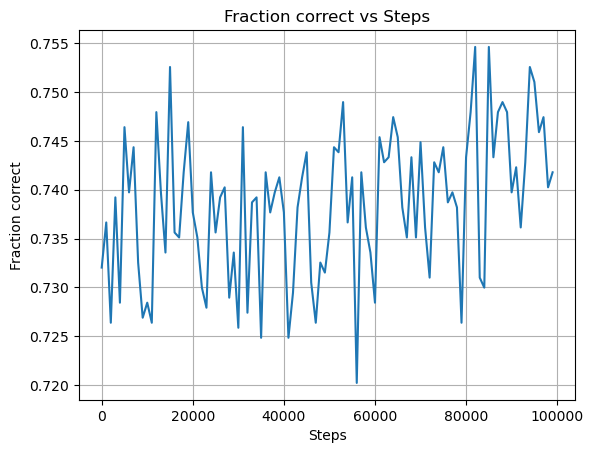

In [48]:
# Plot fraction list vs steps
def plotFractionCorrectVsSteps(fractionList, steps):
    plt.plot(steps, fractionList)
    plt.xlabel("Steps")
    plt.ylabel("Fraction correct")
    plt.title("Fraction correct vs Steps")
    plt.grid()
    plt.show()

steps = np.arange(0, len(fraction_list) * 1000, 1000)
plotFractionCorrectVsSteps(fraction_list, steps)

Average gradient over ten images and step, then optimize with jax.vmap

In [52]:
# This should be in a cell BEFORE cell 50
# Make sure 'net' function is defined before this (e.g., cell 18).

# Vectorize the network prediction function to operate on a batch of images
batched_net = jax.vmap(net, in_axes=(None, 0)) # Pass params as is, map over images

@jax.jit
def fast_fractionCorrect(params_jax, images_jax, labels_jax):
    predictions = batched_net(params_jax, images_jax)
    predicted_classes = jnp.argmax(predictions, axis=1)
    true_classes = jnp.argmax(labels_jax, axis=1)
    return jnp.mean(predicted_classes == true_classes)

Initial fraction correct on test set: 0.7577002048492432
Iteration 0/20000, Fraction correct on test set: 0.7577002048492432
Iteration 2000/20000, Fraction correct on test set: 0.7494866847991943
Iteration 4000/20000, Fraction correct on test set: 0.7546201348304749
Iteration 6000/20000, Fraction correct on test set: 0.7597536444664001
Iteration 8000/20000, Fraction correct on test set: 0.7551335096359253
Iteration 10000/20000, Fraction correct on test set: 0.7577002048492432
Iteration 12000/20000, Fraction correct on test set: 0.7566735148429871
Iteration 14000/20000, Fraction correct on test set: 0.7566735148429871
Iteration 16000/20000, Fraction correct on test set: 0.7597536444664001
Iteration 18000/20000, Fraction correct on test set: 0.7515400648117065
Final fraction correct on test set: 0.7551335096359253


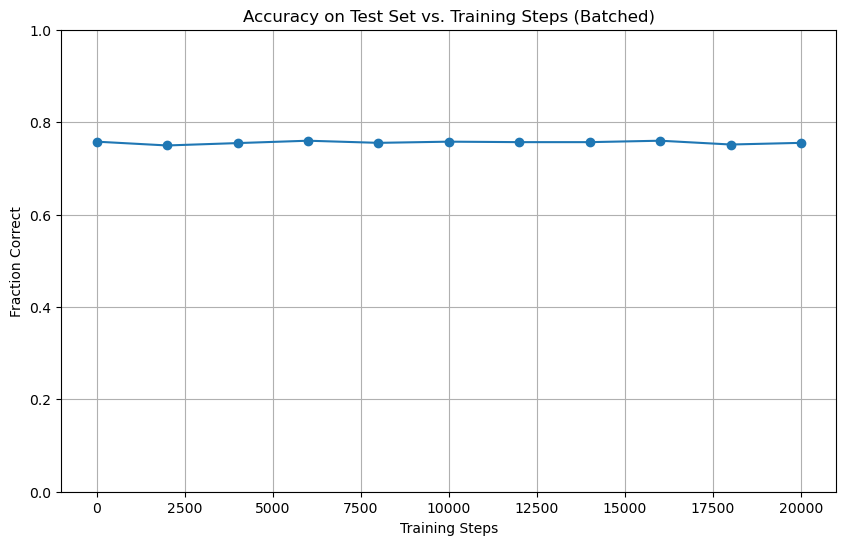

In [53]:
# Ensure 'loss' function is defined (e.g., cell 20)
# Ensure 'params' is a dictionary of JAX arrays (conversion after cell 18)
# Ensure 'train_images', 'train_labels', 'test_images', 'test_labels' are JAX arrays (conversion after cell 14)
# Ensure 'fast_fractionCorrect' is defined in a cell above this one.

batch_loss_grad = jax.jit(jax.vmap(jax.grad(loss), in_axes=(None, 0, 0)))

def compute_batch_gradients(params_jax, images_jax, labels_jax):
    batched_grads_dict = batch_loss_grad(params_jax, images_jax, labels_jax)
    mean_grads_dict = {
        key: jnp.mean(grad_array, axis=0)
        for key, grad_array in batched_grads_dict.items()
    }
    return mean_grads_dict

fraction_list = []
batch_size = 10 # You can experiment with larger batch sizes like 32 or 64

# Initial accuracy check
# Ensure params is the JAX version if you re-ran initialization
initial_accuracy = float(fast_fractionCorrect(params, test_images, test_labels))
print(f"Initial fraction correct on test set: {initial_accuracy}")

num_epochs = 10 # Reduced for faster testing, original was 50
iterations_per_epoch = 2000
total_iterations = num_epochs * iterations_per_epoch

for i in range(total_iterations):
    # Create a batch of JAX arrays
    indices = np.random.choice(train_images.shape[0], batch_size, replace=False)
    batch_images = train_images[indices]
    batch_labels = train_labels[indices]

    gradients = compute_batch_gradients(params, batch_images, batch_labels)

    # Update parameters (which are JAX arrays)
    params[0] -= 0.001 * gradients[0]
    params[1] -= 0.001 * gradients[1]
    params[2] -= 0.001 * gradients[2]
    params[3] -= 0.001 * gradients[3]

    if i % iterations_per_epoch == 0: # Log accuracy every 'epoch'
        current_accuracy = float(fast_fractionCorrect(params, test_images, test_labels))
        fraction_list.append(current_accuracy)
        print(f"Iteration {i}/{total_iterations}, Fraction correct on test set: {current_accuracy}")

# Final accuracy check
final_accuracy = float(fast_fractionCorrect(params, test_images, test_labels))
print(f"Final fraction correct on test set: {final_accuracy}")
if i % iterations_per_epoch != 0 : # Add last accuracy if not already added
    fraction_list.append(final_accuracy)


# Plotting
# Adjust steps based on how often you record accuracy
plot_steps = np.arange(0, total_iterations + 1, iterations_per_epoch)[:len(fraction_list)]


plt.figure(figsize=(10, 6))
plt.plot(plot_steps, fraction_list, marker='o', linestyle='-')
plt.title("Accuracy on Test Set vs. Training Steps (Batched)")
plt.xlabel("Training Steps")
plt.ylabel("Fraction Correct")
plt.grid(True)
plt.ylim(0, 1) # Optional: set y-axis limits for better comparison
plt.show()